### Default Loan Prediction Model 

In [1]:
#Importing all the necessary packages required

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import learning_curve,StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Reading the new csv file created after data cleaning 

In [2]:
df_new = pd.read_csv('df_selected_columns.csv')

In [3]:
df_new.shape

(1325535, 29)

In [4]:
df_new.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,initial_list_status,total_rec_int,application_type,acc_open_past_24mths,mort_acc,num_rev_accts,issue_year,issue_month,earliest_cr_year,credit_history
0,30000,36 months,22.35,D,5,MORTGAGE,100000.0,0,Fully Paid,debt_consolidation,...,1,26.44,1,4.0,1.0,8.0,2018,Dec,2012,6
1,40000,60 months,16.14,C,1,MORTGAGE,45000.0,0,Fully Paid,credit_card,...,1,856.68,1,5.0,1.0,10.0,2018,Dec,2009,9
2,20000,36 months,7.56,A,10,MORTGAGE,100000.0,1,Fully Paid,credit_card,...,1,215.79,1,5.0,5.0,9.0,2018,Dec,1999,19
3,4500,36 months,11.31,B,10,RENT,38500.0,1,Fully Paid,credit_card,...,1,49.22,0,8.0,0.0,15.0,2018,Dec,2003,15
4,8425,36 months,27.27,E,3,MORTGAGE,450000.0,0,Fully Paid,credit_card,...,1,310.15,1,10.0,4.0,17.0,2018,Dec,1997,21


### Finding the correlation between each and every variables

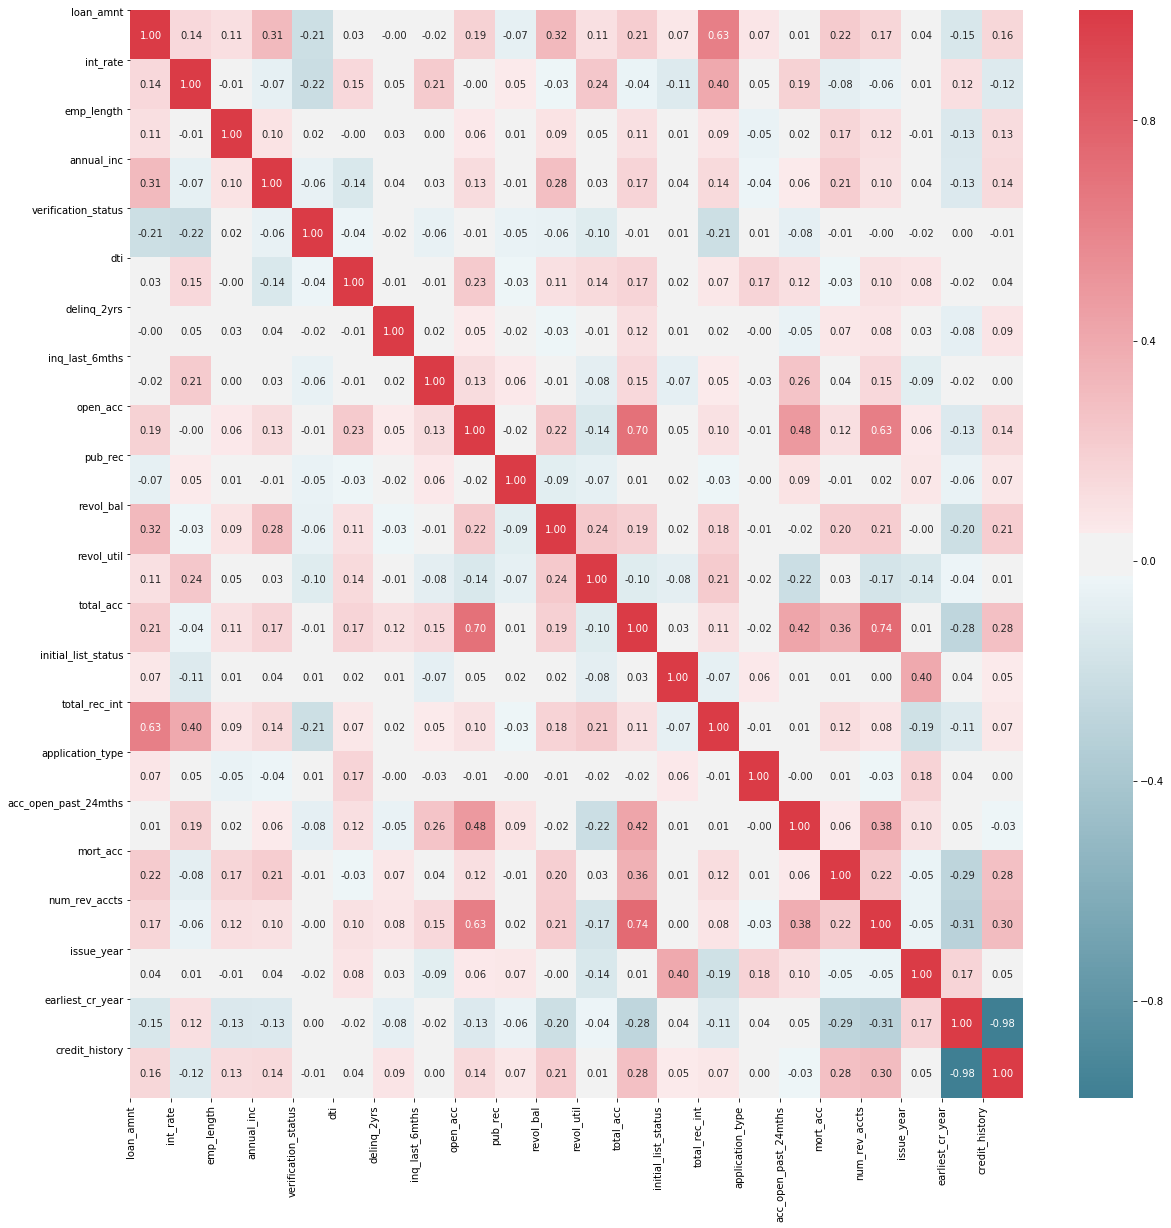

In [5]:
corr = df_new.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(20, 20))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

We can see that few features are highly correlated 

In [6]:
df_new.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

,feature_type,count
0,int64,9
1,float64,13
2,object,7


#### The target variable 'Loan Status' has two possible outcomes:

We are setting the value of 0-->Defaulter
and 1-->Fully Paid

In [7]:
df_new['loan_status'] = df_new['loan_status'].map(lambda x: 1 if x == 'Fully Paid' else 0)

In [8]:
df_new['loan_status'].value_counts()

1    1041952
0     283583
Name: loan_status, dtype: int64

In [9]:
df_new.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

,feature_type,count
0,int64,10
1,float64,13
2,object,6


We can see that there are 6 columns with object datatype and we need to convert them into numerical features

In [10]:
k=0
for i in range(len(df_new.columns)):
    if df_new.iloc[:,i].dtype == 'O':
        df_new.iloc[:,i] = pd.factorize(df_new.iloc[:,i])[0]

In [11]:
df_new.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

,feature_type,count
0,int64,16
1,float64,13


In [12]:
df_new.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,initial_list_status,total_rec_int,application_type,acc_open_past_24mths,mort_acc,num_rev_accts,issue_year,issue_month,earliest_cr_year,credit_history
0,30000,0,22.35,0,5,0,100000.0,0,1,0,...,1,26.44,1,4.0,1.0,8.0,2018,0,2012,6
1,40000,1,16.14,1,1,0,45000.0,0,1,1,...,1,856.68,1,5.0,1.0,10.0,2018,0,2009,9
2,20000,0,7.56,2,10,0,100000.0,1,1,1,...,1,215.79,1,5.0,5.0,9.0,2018,0,1999,19
3,4500,0,11.31,3,10,1,38500.0,1,1,1,...,1,49.22,0,8.0,0.0,15.0,2018,0,2003,15
4,8425,0,27.27,4,3,0,450000.0,0,1,1,...,1,310.15,1,10.0,4.0,17.0,2018,0,1997,21


The loan status has the following count for each type:
    1.Fully Paid
    0.Defaulter

In [13]:
df_new['loan_status'].value_counts()

1    1041952
0     283583
Name: loan_status, dtype: int64

In [14]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    #print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))
    print('MAE:\n{}\n'.format(mean_absolute_error(ytest,ypred)))
    mse=mean_squared_error(ytest,ypred)
    print('MSE:\n{}\n'.format(mse))
    r2 =r2_score(ytest,ypred)
    print('R2:\n{}\n'.format(r2))
    cm = confusion_matrix(ytest,ypred)
    sns.heatmap(cm, annot=True,fmt='d')
    plt.title('Confusion Matrix')
    plt.show()

In [15]:
df_new.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_rec_int', 'application_type',
       'acc_open_past_24mths', 'mort_acc', 'num_rev_accts', 'issue_year',
       'issue_month', 'earliest_cr_year', 'credit_history'],
      dtype='object')

### Since we have still a lot of features, we will be training the model using Random Forest Classifier and find the important features to take into consideration

In [16]:
X = df_new.drop('loan_status',axis=1)
Y = df_new['loan_status']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25) 


In [17]:
X_train.shape

(994151, 28)

In [18]:
Y_train.shape

(994151,)

In [19]:
X_test.shape

(331384, 28)

In [20]:
Y_test.shape

(331384,)

In [21]:
Y_test.shape

(331384,)

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Using Random Forest Classifier to find the important features

In [23]:
rand_class = RandomForestClassifier(n_estimators = 100,random_state=2,max_depth=10)
rand_class.fit(X_train, Y_train)
pred_ran = rand_class.predict(X_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.64      0.07      0.13     71093
           1       0.80      0.99      0.88    260291

    accuracy                           0.79    331384
   macro avg       0.72      0.53      0.50    331384
weighted avg       0.76      0.79      0.72    331384


Confusion matrix: 
[[  5013  66080]
 [  2763 257528]]

MAE:
0.20774388624677112

MSE:
0.20774388624677112

R2:
-0.23283606423625014



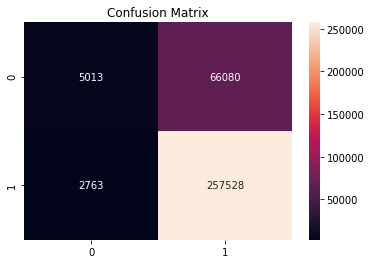

In [24]:
evaluate_model(Y_test, pred_ran)

Variable: int_rate                       Importance: 0.27685
Variable: grade                          Importance: 0.17298
Variable: term                           Importance: 0.14647
Variable: initial_list_status            Importance: 0.07807
Variable: num_rev_accts                  Importance: 0.06813
Variable: addr_state                     Importance: 0.03896
Variable: acc_open_past_24mths           Importance: 0.03636
Variable: loan_amnt                      Importance: 0.02972
Variable: application_type               Importance: 0.02808
Variable: home_ownership                 Importance: 0.02094
Variable: annual_inc                     Importance: 0.01857
Variable: verification_status            Importance: 0.01484
Variable: emp_length                     Importance: 0.01057
Variable: revol_bal                      Importance: 0.01
Variable: pub_rec                        Importance: 0.00766
Variable: issue_month                    Importance: 0.00706
Variable: revol_util       

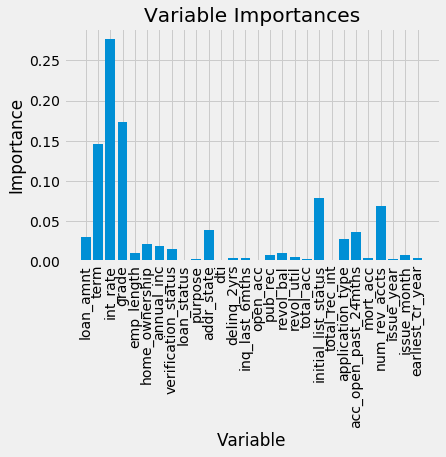

In [25]:
#Plotting a graph to find the most important features

a = df_new.columns

importances = list(rand_class.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(a, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];


# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, a, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


In [26]:
features=['loan_status','total_rec_int','verification_status','issue_year','issue_month','earliest_cr_year','open_acc','home_ownership','pub_rec','addr_state','delinq_2yrs','total_acc']
X=df_new.drop(features,axis=1)


In [27]:
X.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'annual_inc',
       'purpose', 'dti', 'inq_last_6mths', 'revol_bal', 'revol_util',
       'initial_list_status', 'application_type', 'acc_open_past_24mths',
       'mort_acc', 'num_rev_accts', 'credit_history'],
      dtype='object')

After dropping the least important features we are left with 17 features and we would be taking those into consideration.

Assigning the target variable loan status

In [28]:
Y = df_new['loan_status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25) 

In [29]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model-1
### Logistic Regression

In [30]:
reg = LogisticRegression()
reg.fit(X_train, Y_train)
y_pred_log = reg.predict(X_test)

Accuracy of the model: 78.82456606233252
Classification report: 
              precision    recall  f1-score   support

           0       0.53      0.08      0.15     70830
           1       0.80      0.98      0.88    260554

    accuracy                           0.79    331384
   macro avg       0.66      0.53      0.51    331384
weighted avg       0.74      0.79      0.72    331384


Confusion matrix: 
[[  5972  64858]
 [  5314 255240]]

MAE:
0.2117543393766748

MSE:
0.2117543393766748

R2:
-0.2600286032869692



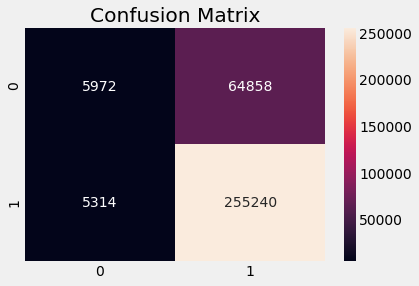

In [31]:
acc_log= accuracy_score(Y_test,y_pred_log)* 100
print('Accuracy of the model:',acc_log)
evaluate_model(Y_test, y_pred_log)

### Model-2

### Random Forest

In [44]:
rand_class = RandomForestClassifier(n_estimators = 10,random_state=2,max_depth=8)
rand_class.fit(X_train, Y_train)
y_pred_ran = rand_class.predict(X_test)

Accuracy of the model: 78.93652077348334
Classification report: 
              precision    recall  f1-score   support

           0       0.58      0.05      0.10     70830
           1       0.79      0.99      0.88    260554

    accuracy                           0.79    331384
   macro avg       0.69      0.52      0.49    331384
weighted avg       0.75      0.79      0.71    331384


Confusion matrix: 
[[  3783  67047]
 [  2754 257800]]

MAE:
0.21063479226516668

MSE:
0.21063479226516668

R2:
-0.2533668206411921



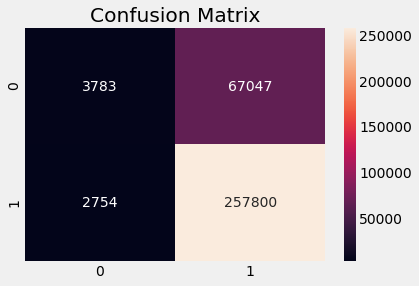

In [45]:
acc_ran= accuracy_score(Y_test,y_pred_ran)* 100
print('Accuracy of the model:',acc_ran)
evaluate_model(Y_test, y_pred_ran)

### Model-3 
### XGBoost



In [34]:
model = XGBClassifier()
model.fit(X_train, Y_train)
y_pred_xg = model.predict(X_test)


Accuracy of the model: 79.06054607343746
Classification report: 
              precision    recall  f1-score   support

           0       0.40      0.23      0.29     70830
           1       0.81      0.90      0.86    260554

    accuracy                           0.76    331384
   macro avg       0.61      0.57      0.57    331384
weighted avg       0.72      0.76      0.74    331384


Confusion matrix: 
[[ 16497  54333]
 [ 24975 235579]]

MAE:
0.23932356420346185

MSE:
0.23932356420346185

R2:
-0.42407724547516024



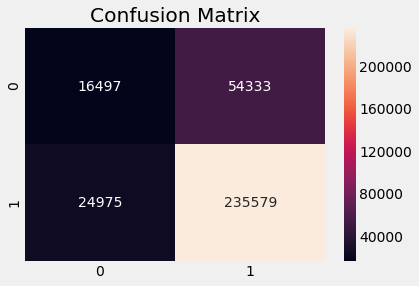

In [35]:
acc_xg= accuracy_score(Y_test,y_pred_xg)* 100
print('Accuracy of the model:',acc_xg)
evaluate_model(Y_test, y_pred_ran)

### Model-4 

### Naive Bayes



In [36]:
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred_naiv = gnb.predict(X_test)


Accuracy of the model: 75.91887357265288
Classification report: 
              precision    recall  f1-score   support

           0       0.41      0.31      0.35     70830
           1       0.82      0.88      0.85    260554

    accuracy                           0.76    331384
   macro avg       0.62      0.59      0.60    331384
weighted avg       0.74      0.76      0.75    331384


Confusion matrix: 
[[ 21621  49209]
 [ 30592 229962]]

MAE:
0.24081126427347127

MSE:
0.24081126427347127

R2:
-0.4329296951904382



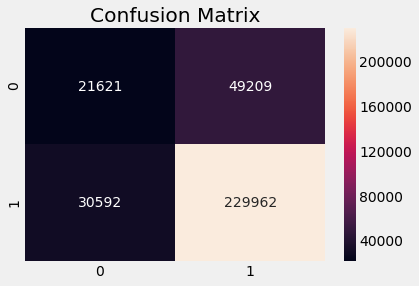

In [43]:
acc_nav= accuracy_score(Y_test,y_pred_naiv)* 100
print('Accuracy of the model:',acc_nav)
from sklearn.metrics import precision_score,recall_score,f1_score
evaluate_model(Y_test,y_pred_naiv)

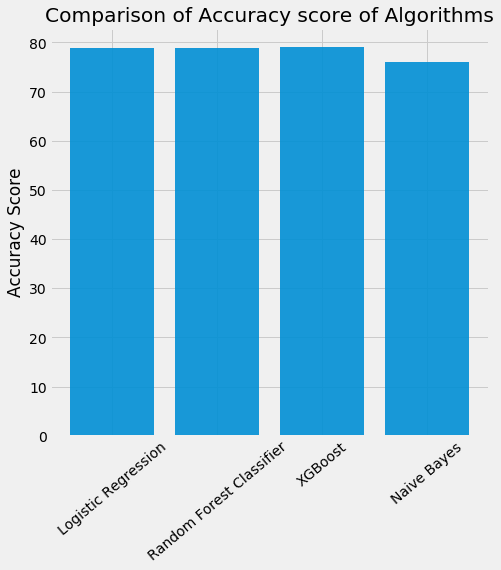

In [46]:
#Plotting the comparison of Models


models=('Logistic Regression','Random Forest Classifier','XGBoost','Naive Bayes')
y_pos=np.arange(len(models))
performance=[acc_log,acc_ran,acc_xg,acc_nav]
plt.figure(figsize=(7,7))
plt.bar(y_pos,performance,align='center', alpha=0.9)
plt.xticks(y_pos, models, rotation=40)

plt.ylabel('Accuracy Score')
plt.title('Comparison of Accuracy score of Algorithms')
plt.show()

In [39]:
print('Accuracy of the Logistic Regression:',acc_log)
print('Accuracy of the Random Forest Classifier:',acc_ran)
print('Accuracy of the XGBoost:',acc_xg)
print('Accuracy of the Naive Bayes:',acc_nav)

Accuracy of the Logistic Regression: 78.82456606233252
Accuracy of the Random Forest Classifier: 76.06764357965382
Accuracy of the XGBoost: 79.06054607343746
Accuracy of the Naive Bayes: 75.91887357265288


## Summary and Observations:


- The dataset consists of 2.26 M points and 145 columns hence we had to reduce the columns and select only required feature.
- We started of with some Exploratory data analysis just to see the corelation between variable and columns which are importatn
- Once we did some EDA we started cleaning the dataset
- We removed columns which had majority missing values (>50%)
- Based on real world financial importance we kept columns which are required such as loan_amt, credit_score etc.
- We started plotting and removed columns which were reduntant. For ex: loan_amt and funded_amt were similar hence we removed funded_amt. In a similar way we removed many columns which were reduntant
- We also imputed some of the null values using mean of the columns as some of the features are important and it is required and we had to handle the null values in the column
- Once we had the clean dataset.
- We passed the dataset to Random forest classifier to see which all variables are important and we could get top features from the algorithm and selected the top features which we got from the algorithm
- We split the dataset into training and testing set
- We trained our model using various classification algorithm 
- Testing the model on the test data
- Used various evaluation metric such as Confusion matrix, MSE,R2 etc to check how our model is performing
- Compared the results of our model to see which was performing better
- Accuracy of 79.06% model performed the best
- We could predict whether a person turns out to be a defaulter or not
- We can improve our model performance by using a different algorithm also feature selection can be optimized by a different algorithm